In [10]:
#
#
#   Speaker Identification.
#   Data comes from http://www.openslr.org/12/
#   Task: Given 't' seconds of speech, identify the speaker.
#   10-class classification: 5 male and 5 female speakers.
#   Training on about 10 minutes of speech per speaker.
#
#
import soundfile as sf            # To read .flac files.   
import speech_recognition as sr   # pip install SpeechRecognition.

import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# For the neural network.
# Install PyBrain, e.g. pip install pybrain.
from pybrain.datasets                import ClassificationDataSet
from pybrain.tools.shortcuts         import buildNetwork
from pybrain.supervised.trainers     import BackpropTrainer
from pybrain.structure.modules       import SoftmaxLayer
from pybrain.tools.customxml.networkreader import NetworkReader
from pybrain.tools.customxml.networkwriter import NetworkWriter
# from pybrain.tools.xml.networkreader import NetworkReader
# from pybrain.tools.xml.networkwriter import NetworkWriter

from pybrain.structure import FullConnection
from pybrain.structure import FeedForwardNetwork
from pybrain.structure import LinearLayer
from pybrain.structure import SoftmaxLayer
from pybrain.structure import TanhLayer

sq = lambda x: x*x

durationCheck = 10.      # Only consider files with 10 or more seconds of audio.
deltaT        = 0.2      # Audio frame size is 0.2 seconds.
noisy         = 0.1      # This sets the limit for static, i.e. pauses in speech.
lim1 = 10; lim2 = 410    # Lower and upper frequencies. 
                         # For the above parameters and 16 kHz sampling, this range is about 50 - 2000 Hz.  
audioType  = ".flac"               # Flac files. 
path       = "../LibriSpeech-SI/"        # Path where audio files are located.
trainSet   = "train/"        # Training set.
cvSet      = "train/"           # Cross-Validation set.
tstSet     = "test/"         # Test set. 
maxminFile = "min_max_values.dat"  # File to store max and min values for each frequency bin.
outfolder  = "result/"           # Folder to store trained networks.
stem       = "nn"                  # Output network filename stem.    

# These are the speakers.
# Female: 19, 32, 39, 40, 83
# Male: 26, 27, 78, 405, 196
speakers = ["spk019/",
            "spk026/",
            "spk032/",
            "spk027/",
            "spk039/",
            "spk078/",
            "spk040/",
            "spk405/", 
            "spk083/",
            "spk196/"]

numFeatures = lim2-lim1
numSpeakers = len(speakers)

In [11]:
# Read data from a folder into a list.
def getData(division,speaker):
  fname = path+division+speaker  
  subPaths = [v+"/" for v in os.listdir(fname) if v[0] != "."]
  dataFiles = []
  for subPath in subPaths:
    files = [v for v in os.listdir(fname+subPath) if v[0] != "." and audioType in v]
    for fil in files:
      data,samplerate = sf.read(fname+subPath+fil)  
      duration = len(data)*1./samplerate
      if duration >= durationCheck: dataFiles.append(fname+subPath+fil)
        
  chunksF = []

  for fil in dataFiles:
    data,samplerate = sf.read(fil)  
    duration = len(data)*1./samplerate

    # Divide audio data into frames, or chunks. 
    numChunks = int(duration/deltaT)
    sizeChunk = int(len(data)/numChunks)
    for lp in range(0,numChunks):    
      chunk = data[lp*sizeChunk:(lp+1)*sizeChunk]      # get a chunk of speech.     
      chunksF.append(np.abs(np.fft.rfft(chunk))[lim1:lim2])  # take the FFT.

    # Delete quiet parts of speech, i.e. pauses.
    # Most of the power is in the bottom 50% of frequencies.
    mu = np.mean([np.mean(chunksF[i][:numFeatures//2]) for i in range(0,len(chunksF))])
    dataF = []
    for chunkF in chunksF:
      if np.mean(chunkF[:numFeatures//2]) > noisy*mu:
        dataF.append(chunkF)
    
  return dataF

# Return data for all speakers.
def getDataSpeakers(division):
  dataSpeakers = []
  for speaker in speakers:
    print ("Getting data for speaker: "+speaker)
    dataSpeakers.append(getData(division,speaker))

  N = np.sum([np.shape(s)[0] for s in dataSpeakers])
  tX = np.mat(np.zeros((N,numFeatures)))
  tY = []
  speakerIndices = [0]    # Index corresponding to start of speaker 'n'
  
  ctr = 0; lp = 0
  for dataSpeaker in dataSpeakers:
    for j in range(0,len(dataSpeaker)):
      for k in range(0,numFeatures):
        tX[ctr,k] = dataSpeaker[j][k]
      tY.append(lp)
      ctr += 1  
    speakerIndices.append(ctr)
    lp += 1  
          
  return tX,tY,speakerIndices

In [12]:
# Get data,
# as well as locations where speaker 'i' ends, and speaker 'j' begins.
trnX,trnY,trnIdx = getDataSpeakers(trainSet)  

Getting data for speaker: spk019/


NotADirectoryError: [Errno 20] Not a directory: '../LibriSpeech-SI/train/spk019/spk019_109.flac/'

In [4]:
print np.shape(trnX), np.shape(trnY)    
trnRows = np.shape(trnX)[0]
print trnIdx   # Start location of speaker 'i'.

(35396, 400) (35396,)
[0, 3828, 7509, 10908, 13095, 17188, 20396, 24412, 28148, 31672, 35396]


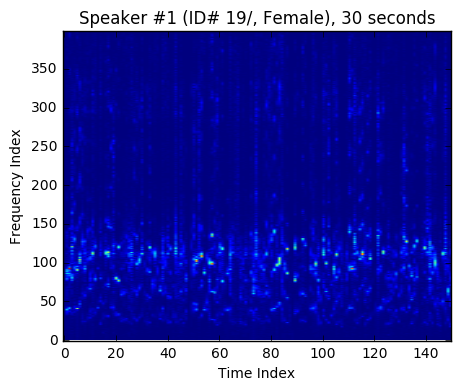

In [5]:
# Make some plots.
# Frequency index from 0...400 represent a range from 50 - 2000 Hz.
# Time index from 0 to 150 represent a range from 0 - 30 seconds.
plt.title("Speaker #1 (ID# 19/, Female), 30 seconds")
plt.xlabel("Time Index")
plt.ylabel("Frequency Index")
plt.imshow(trnX[trnIdx[0]:trnIdx[0]+150,:].T,origin="lower",aspect=0.3)

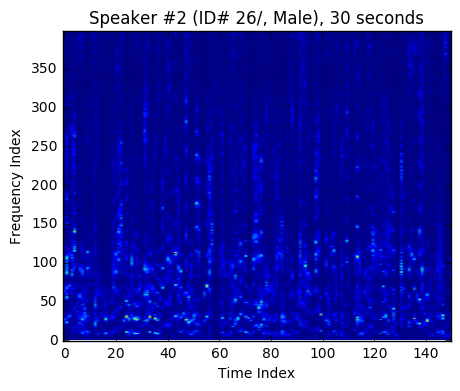

In [6]:
plt.title("Speaker #2 (ID# 26/, Male), 30 seconds")
plt.xlabel("Time Index")
plt.ylabel("Frequency Index")
plt.imshow(trnX[trnIdx[1]:trnIdx[1]+150,:].T,origin="lower",aspect=0.3)

In [7]:
# Find min and max values for each frequency bin using Training data only.
# Normalize data to lie in the range (0,1).
minArray = []; maxArray = []
for i in range(0,numFeatures):
  minArray.append(np.min(trnX[:,i]))
  maxArray.append(np.max(trnX[:,i]))    

f = open(maxminFile, "w")
for i in range(0,numFeatures):
  f.write(str(maxArray[i]) + " " + str(minArray[i]) + "\n")
f.close()      

for i in range(0,trnRows):
  for j in range(0,numFeatures):
    trnX[i,j] = (trnX[i,j]-minArray[j])/(maxArray[j]-minArray[j])  

In [8]:
# 
# This is the architecture of the network.
# Hyper-parameters to be fixed through cross-validation are:
#                         (i)   How many layers are necessary?
#                         (ii)  How many nodes per layer?
#                         (iii) What kind of activation function to use?
# 
def setupNetwork(numHiddenNodes,numHiddenLayers):
    
  nn = FeedForwardNetwork()
  inputLayer = LinearLayer(numFeatures)
  nn.addInputModule(inputLayer)
  
  hiddenLayers = []
  for x in range(numHiddenLayers):
    hiddenLayer = TanhLayer(numHiddenNodes)    
    nn.addModule(hiddenLayer)
    hiddenLayers.append(hiddenLayer)
  outputLayer = SoftmaxLayer(numSpeakers)
  nn.addOutputModule(outputLayer)
  
  inputConnection = FullConnection(inputLayer,hiddenLayers[0])
  nn.addConnection(inputConnection)
  
  for x in range(numHiddenLayers-1):
    connect = FullConnection(hiddenLayers[x],hiddenLayers[x-1])
    nn.addConnection(connect)

  outputConnection = FullConnection(hiddenLayers[numHiddenLayers-1],outputLayer)    
  nn.addConnection(outputConnection)
  nn.sortModules()
  
  return nn

In [9]:
#
# Now, we train the neural network.
#
possibleOutputs   = 1       # Only 1 kind of output, i.e. each sample is one speaker.
numHiddenNodes    = 10      # Nodes per hidden layer.
numHiddenLayers   = 5       # 5 layers.
numTrainingEpochs = 10      # Train 'n' epochs.

trndata = ClassificationDataSet(numFeatures, possibleOutputs, nb_classes=numSpeakers)
for row in range(0,trnRows):
  tempListOut = []; tempListIn = []
  tempListOut.append(int(trnY[row]))
  for i in range(0,numFeatures): 
    tempListIn.append(trnX[row,i])
    
  trndata.addSample(tempListIn,tempListOut)
trndata._convertToOneOfMany()

#first = True            # Set up a network.
first = False            # We already have a network.
nnFile = "nn69.xml"      # Most recent. Starting file name to read from.
st = 70                  # Starting file to write to.

if first:    # For the first time, we need to create the neural network.
  nn = setupNetwork(numHiddenNodes,numHiddenLayers)

else:        # We already have a network.
  nn = NetworkReader.readFrom(outfolder+nnFile)
    
trainer = BackpropTrainer(nn, dataset=trndata, momentum=0., verbose=True, weightdecay=0.)  
for i in range(numTrainingEpochs): 
  trainer.trainOnDataset(dataset=trndata)    
  if (i+1)%5 == 0:
    NetworkWriter.writeToFile(nn, outfolder+stem+str(st)+".xml")  # Save the network, to save time.
    st += 1
    print i+1

Total error: 0.0147598914333
Total error: 0.014762537636
Total error: 0.0147900170153
Total error: 0.0147720298129
Total error: 0.0148310149973
5
Total error: 0.0147985833919
Total error: 0.0148153232509
Total error: 0.014764021512
Total error: 0.0147376760302
Total error: 0.0147440246495
10


In [10]:
#
# Test the classifier.
# nns is a list of trained networks. It is sometimes helpful to pass more than one network,
# since errors made by different networks may cancel out.
# tX: Data to test
# tY: Target, i.e. speaker ID.
# idx: List of indices indicating the starting location of a speaker.
# skip: Number of increments of 'deltaT' to group together. For e.g. if 'deltaT' = 0.2:
#       If skip = 1, a prediction is made for every 0.2 seconds.
#       If skip = 5, a prediction is made for every 1.0 second.
#
def tstClassifier(nns,tX,tY,idx,skip):

  def maxIdx(A):
    # Pick the prediction with the highest occurance.
    ctr = {}
    for pre in A:
      if pre not in ctr: ctr[pre] = 1
      else: ctr[pre] += 1
      
    rev = {}
    for key in ctr.keys():
      rev[ctr[key]] = key
    return rev[np.max(rev.keys())]

  # Confusion matrix: Speaker 'm' predicted as speaker 'n'.
  confusion = np.mat(np.zeros((numSpeakers,numSpeakers)))  
  
  correct = 0; al = 0
  for cvi in range(0,numSpeakers):
    # idx contain the start location of each speaker.
    for lpx in range(idx[cvi],idx[cvi+1]-skip,skip):
      bestArray = []

      # Consider "skip" number of data points together.
      for lp in range(lpx,lpx+skip):      
        A = [tX[lp,i] for i in range(0,numFeatures)]
        prediction = []

        # Average over multiple trained networks.        
        for nn in nns:  
          pred = nn.activate(A)
          ctr = {}
          for i in range(0,numSpeakers):
            ctr[pred[i]] = i
          prediction.append(ctr[np.max(ctr.keys())])
        bestArray.append(maxIdx(prediction))

      best = maxIdx(bestArray)                
      if best == tY[lpx]: correct += 1

      # Populate the confusion matrix.  
      for i in range(0,numSpeakers):
        if best == i: confusion[cvi,i] += 1
      al += 1

  return correct*1./al, confusion

In [11]:
#
# Data for cross-validation and testing.
# We use the cross validation data set to determine the network architecture,
# i.e. depth and width of the network, type of activation function, etc.
#
cvX,cvY,cvIdx = getDataSpeakers(cvSet)  
tstX,tstY,tstIdx = getDataSpeakers(tstSet)  
cvRows = np.shape(cvX)[0]; tstRows = np.shape(tstX)[0]

f = open(maxminFile)    # Read the max and min values obtained from the training set.
maxi = []; mini = []
for lp in range(0,numFeatures):
  line = f.readline().split()
  maxi.append(float(line[0]))
  mini.append(float(line[1]))
f.close()

# Normalize to put data in the range (0,1).
for i in range(0,cvRows):
  for j in range(0,numFeatures):
    cvX[i,j] = (cvX[i,j]-mini[j])/(maxi[j]-mini[j])  

for i in range(0,tstRows):
  for j in range(0,numFeatures):
    tstX[i,j] = (tstX[i,j]-mini[j])/(maxi[j]-mini[j])  

Getting data for speaker: 19/
Getting data for speaker: 26/
Getting data for speaker: 32/
Getting data for speaker: 27/
Getting data for speaker: 39/
Getting data for speaker: 78/
Getting data for speaker: 40/
Getting data for speaker: 405/
Getting data for speaker: 83/
Getting data for speaker: 196/
Getting data for speaker: 19/
Getting data for speaker: 26/
Getting data for speaker: 32/
Getting data for speaker: 27/
Getting data for speaker: 39/
Getting data for speaker: 78/
Getting data for speaker: 40/
Getting data for speaker: 405/
Getting data for speaker: 83/
Getting data for speaker: 196/


In [12]:
#
# Performance on the CV set, as a function of training epoch.
# We stop when we see signs of overfitting.
# Performance on the CV set is also used to determine the neural network architecture.
#
lastN = 70
print "CV Set - Performance on 0.2 seconds of data."
X = []; Y = []
for q in range(0,lastN):
  net = outfolder+stem+str(q)+".xml"
  nn = [NetworkReader.readFrom(net)]
  st = 1
  A,c = tstClassifier(nn,cvX,cvY,cvIdx,st)
  if q%5 == 0:
    print net,st*deltaT,np.mean(A)
  X.append((q+1)*5)
  Y.append(np.mean(A))

CV Set - Performance on 0.2 seconds of data.
networks/nn0.xml 0.2 0.611977206752
networks/nn5.xml 0.2 0.707988388345
networks/nn10.xml 0.2 0.70734329642
networks/nn15.xml 0.2 0.716912159983
networks/nn20.xml 0.2 0.724438232448
networks/nn25.xml 0.2 0.726050962262
networks/nn30.xml 0.2 0.728201268681
networks/nn35.xml 0.2 0.722502956671
networks/nn40.xml 0.2 0.734007096011
networks/nn45.xml 0.2 0.727018600151
networks/nn50.xml 0.2 0.722825502634
networks/nn55.xml 0.2 0.735619825825
networks/nn60.xml 0.2 0.720460165574
networks/nn65.xml 0.2 0.724760778411


In [13]:
#
#  The network is trained using performance on the CV set.
#  Therefore, we cannot report perfomance on the CV set anymore.
#  So, we use the other hold-out data set, i.e. the Test set.
#
print "Test Set - Performance on 0.2 seconds of data."
X = []; Y = []
lastN = 70
for q in range(0,lastN):
  net = outfolder+stem+str(q)+".xml"
  nn = [NetworkReader.readFrom(net)]
  st = 1
  A,c = tstClassifier(nn,tstX,tstY,tstIdx,st)
  if q%5 == 0:
    print net,st*deltaT,np.mean(A)
  X.append((q+1)*5)
  Y.append(np.mean(A))

Test Set - Performance on 0.2 seconds of data.
networks/nn0.xml 0.2 0.614403292181
networks/nn5.xml 0.2 0.702880658436
networks/nn10.xml 0.2 0.705144032922
networks/nn15.xml 0.2 0.723971193416
networks/nn20.xml 0.2 0.732407407407
networks/nn25.xml 0.2 0.726131687243
networks/nn30.xml 0.2 0.731172839506
networks/nn35.xml 0.2 0.721502057613
networks/nn40.xml 0.2 0.733744855967
networks/nn45.xml 0.2 0.727572016461
networks/nn50.xml 0.2 0.724691358025
networks/nn55.xml 0.2 0.734156378601
networks/nn60.xml 0.2 0.722119341564
networks/nn65.xml 0.2 0.721913580247


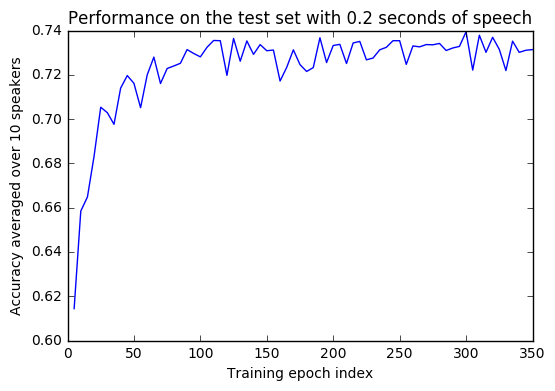

In [14]:
plt.xlabel("Training epoch index")
plt.ylabel("Accuracy averaged over 10 speakers")
plt.title("Performance on the test set with 0.2 seconds of speech")
plt.plot(X,Y)
plt.show()

In [15]:
#
#  Accuracy for t = 0.2,0.4,0.6,0.8,1.0,... seconds.
#
print "Test Set: Accuracy (averaged over speakers) for t = 0.2,0.4,0.6,... seconds"
# Use 5 classifiers - the accuracy improves a little with an ensemble of networks.
# For better results, use networks that were initialized with different random seeds.
nets = ["nn69.xml", "nn67.xml", "nn65.xml", "nn63.xml", "nn61.xml"]
nns = [NetworkReader.readFrom(outfolder+net) for net in nets]
X = []; Y = []
maxT = 3.   # 3 seconds.
for st in range(1,int(maxT/deltaT)+1):
  A,c = tstClassifier(nns,tstX,tstY,tstIdx,st)
  print st*deltaT,np.mean(A)
  X.append(st*deltaT)
  Y.append(np.mean(A))

Test Set: Accuracy (averaged over speakers) for t = 0.2,0.4,0.6,... seconds
0.2 0.739609053498
0.4 0.734252778921
0.6 0.844300278035
0.8 0.883807169345
1.0 0.916967509025
1.2 0.935024752475
1.4 0.948014440433
1.6 0.963666391412
1.8 0.972118959108
2.0 0.970010341262
2.2 0.980637813212
2.4 0.980148883375
2.6 0.985195154778
2.8 0.98115942029
3.0 0.989096573209


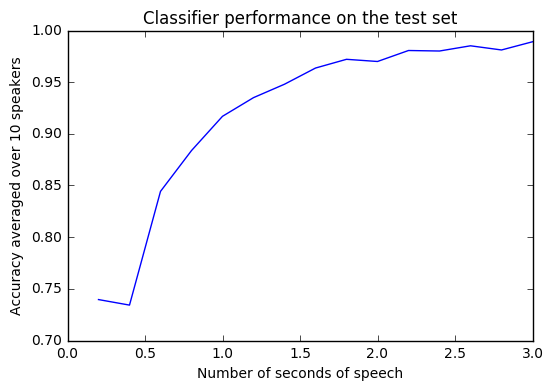

In [16]:
plt.plot(X,Y)
plt.xlabel("Number of seconds of speech")
plt.ylabel("Accuracy averaged over 10 speakers")
plt.title("Classifier performance on the test set")
plt.show()

In [17]:
# Print the confusion matrix of True/False positives.
# First row is speaker 1. The columns are predictions for speaker 1,2,3,...
#
nets = ["nn69.xml", "nn67.xml", "nn65.xml", "nn63.xml", "nn61.xml"]
nns  = [NetworkReader.readFrom(outfolder+net) for net in nets]
A,c = tstClassifier(nns,tstX,tstY,tstIdx,1)
print "Confusion matrix: T = 0.2 s"
print "Predicted speaker -->"
print "F\tM\tF\tM\tF\tM\tF\tM\tF\tM\n"
for i in range(0,np.shape(c)[0]):
  for j in range(0,np.shape(c)[1]):
    print str(int(c[i,j]))+"\t",
  print "\n"[:-1]  
print "\n"[:-1]

A,c = tstClassifier(nns,tstX,tstY,tstIdx,5)
print "Confusion matrix: T = 1 s"
print "Predicted speaker -->"
print "F\tM\tF\tM\tF\tM\tF\tM\tF\tM\n"
for i in range(0,np.shape(c)[0]):
  for j in range(0,np.shape(c)[1]):
    print str(int(c[i,j]))+"\t",
  print "\n"[:-1]  
print "\n"[:-1]

A,c = tstClassifier(nns,tstX,tstY,tstIdx,10)
print "Confusion matrix: T = 2 s"
print "Predicted speaker -->"
print "F\tM\tF\tM\tF\tM\tF\tM\tF\tM\n"
for i in range(0,np.shape(c)[0]):
  for j in range(0,np.shape(c)[1]):
    print str(int(c[i,j]))+"\t",
  print "\n"[:-1]  

Confusion matrix: T = 0.2 s
Predicted speaker -->
F	M	F	M	F	M	F	M	F	M

992	2	66	0	21	0	6	0	51	1	
4	760	45	68	27	67	14	39	2	46	
43	29	646	4	72	1	59	3	58	6	
2	62	15	430	19	4	7	35	9	65	
8	5	39	8	787	7	43	0	79	12	
0	65	5	5	4	728	3	45	0	22	
6	9	47	2	61	2	809	0	72	6	
1	77	6	61	2	30	2	620	1	174	
51	1	45	0	61	0	58	1	693	0	
5	73	20	91	35	26	28	171	4	724	

Confusion matrix: T = 1 s
Predicted speaker -->
F	M	F	M	F	M	F	M	F	M

224	0	2	0	1	0	0	0	0	0	
0	194	0	6	0	6	0	3	0	5	
2	0	166	0	7	0	6	0	3	0	
0	3	1	112	1	0	0	5	1	6	
0	1	0	0	192	0	2	0	2	0	
0	1	0	0	0	170	0	1	0	3	
0	0	0	0	3	0	196	0	3	0	
0	2	1	4	0	1	0	167	0	19	
2	0	2	0	4	0	5	0	169	0	
0	3	2	9	2	2	2	27	0	188	

Confusion matrix: T = 2 s
Predicted speaker -->
F	M	F	M	F	M	F	M	F	M

113	0	0	0	0	0	0	0	0	0	
0	105	0	1	0	1	0	0	0	0	
0	0	91	0	1	0	0	0	0	0	
0	0	0	61	0	0	0	1	0	2	
0	0	0	0	98	0	0	0	0	0	
0	0	0	0	0	86	0	0	0	1	
0	0	0	0	1	0	99	0	1	0	
0	0	0	1	0	0	0	89	0	7	
0	0	0	0	1	0	0	0	90	0	
0	0	0	2	0	0	0	9	0	106	


In [18]:
samples = [path+tstSet+"19/227/19-227-0017.flac",
           path+tstSet+"26/496/26-496-0019.flac",
           path+tstSet+"405/130895/405-130895-0030.flac"]

expected = [
"Mrs. Morland had been always kindly disposed towards each, and instantly pleased \
by his appearance, received him with the simple professions of unaffected benevolence, \
thanking him for such an attention to her daughter",
  
"Among the wealthiest of the people, and such people as were unencumbered \
with trades and business, but of the rest, the generality stayed, and seemed \
to abide the worst, so that",
  
"Some of these jellyfish were shaped like very smooth semispheric parasols \
with russet stripes, and fringes of twelve neat festoons. Others looked like"
]

r = sr.Recognizer()
i = 0
for sample in samples:
  with sr.AudioFile(sample) as source:
    audio = r.record(source)      
    s = r.recognize_google(audio)
    print "Reading file: " + sample
    print "Expected:"
    print expected[i]
    print "\n"[:-1]
    print "Obtained (Google translator):"
    print s
    print "\n"[:-1]
    i += 1

Reading file: LibriSpeech/test-clean/19/227/19-227-0017.flac
Expected:
Mrs. Morland had been always kindly disposed towards each, and instantly pleased by his appearance, received him with the simple professions of unaffected benevolence, thanking him for such an attention to her daughter

Obtained (Google translator):
mrs. Moreland had been always kindly disposed towards each and instantly pleased by his appearance received him with the simple professions of unaffected benevolence thanking him for such an attention to her daughter

Reading file: LibriSpeech/test-clean/26/496/26-496-0019.flac
Expected:
Among the wealthiest of the people, and such people as were unencumbered with trades and business, but of the rest, the generality stayed, and seemed to abide the worst, so that

Obtained (Google translator):
among the wealthiest of the people and such people as we unencumbered with trades and business but of the rest the generality stayed and seemed to abide the worst so that

Reading f